Authors: Federico Gritti, Kadir Oezden, Fanni Véh

# Sorting Berries Robot Arm Control: A Comparison between Resolved Rate of Motion and Joint Space Trajectory Interpolation




In [2]:
from email import errors
from shutil import move
from matplotlib.pylab import box
import swift
import roboticstoolbox as rtb
import spatialgeometry as sg
import spatialmath as sm
import numpy as np
import time
import matplotlib.pyplot as plt

red = [1, 0, 0]
green = [0, 1, 0]
blue = [0, 0, 1]
orange = [1, 0.5, 0]
colors = [red, green, blue]

light_red = [1, 0.8, 0.8]
light_green = [0.8, 1, 0.8]
light_blue = [0.8, 0.8, 1]


class Berry:
    def __init__(self, radius, position, color, table_position_z, table_height):
        self.table_position_z = table_position_z
        self.table_height = table_height
        self.radius = radius
        self.random_color = color
        self.is_picked = False
        self.std_pose_z = table_position_z + table_height/2 + self.radius
        
        self._sphere = sg.Sphere(radius=radius, pose=position, color=self.random_color)
        
    @property
    def pose(self):
        return sm.SE3(self._sphere.T)

    @property
    def swift(self):
        return self._sphere
    
    def eat(self):
        self._sphere.T = sm.SE3(0, 0, 1000).A
    
    def set_position(self, x, y, z):
        self._sphere.T = sm.SE3(x, y, z).A

    def pick_up(self):
        self.is_picked = True

    def drop_at_position(self, position):
        self.is_picked = False
        drop_position = sm.SE3(position.x, position.y, self.std_pose_z - 0.03)
        self.set_position(drop_position.x, drop_position.y, drop_position.z)
        
    def update_position_to_end_effector(self, end_effector_pose):
        if self.is_picked:
            berry_offset = sm.SE3(0, 0, -self.radius)
            new_position = end_effector_pose * berry_offset
            self.set_position(new_position.x, new_position.y, new_position.z)

    def get_drop_position_by_color(self, box1_pos, box2_pos, box3_pos):
        if np.array_equal(self.random_color, red):
            return box1_pos
        elif np.array_equal(self.random_color, green):
            return box2_pos
        elif np.array_equal(self.random_color, blue):
            return box3_pos
        else:
            return None

class Box:
    def __init__(self, width, depth, height, position, color=[0.9, 0.9, 0.9], wall_thickness=0.02):
        self.width = width
        self.depth = depth
        self.height = height
        self.position = position
        self.color = color
        self.wall_thickness = wall_thickness
        self.boxes = []
        bottom = sg.Cuboid(scale=[width, depth, wall_thickness],pose=sm.SE3(position.x, position.y, position.z - height/2 + wall_thickness/2), color=color)
        self.boxes.append(bottom)
        front = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y - depth/2 + wall_thickness/2, position.z),color=color)
        self.boxes.append(front)
        back = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y + depth/2 - wall_thickness/2, position.z), color=color)
        self.boxes.append(back)
        left = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness],pose=sm.SE3(position.x - width/2 + wall_thickness/2, position.y, position.z),color=color)
        self.boxes.append(left)
        right = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x + width/2 - wall_thickness/2, position.y, position.z), color=color)
        self.boxes.append(right)

    @property
    def swift(self):
        return self.boxes
    
class Table:    
    def __init__(self, x, y, z, depth, width, height, color):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.depth = float(depth)
        self.width = float(width)
        self.height = float(height) 
        self._cuboid = sg.Cuboid(scale=[self.depth, self.width, self.height], pose=sm.SE3(self.x, self.y, self.z), color=color)
    
    @property
    def table_position_z(self):
        return float(self.z)
    
    @property
    def table_height(self):
        return float(self.height)
    
    @property
    def swift(self):
        return self._cuboid
    
    @swift.setter
    def swift(self, swift):
        self._cuboid = swift

class Cylinder:
    def __init__(self, radius, height, position, color):
        self.radius = radius
        self.height = height
        self.position = position
        self._cylinder = sg.Cylinder(radius=radius, length=height, pose=position, color=color)
    
    @property
    def swift(self):
        return self._cylinder

class RobotResolvedRate:
    def __init__(self, base_position=sm.SE3(0,0,0)):
        self.dt = 0.01
        self.error = np.ones((3,1))
        self.gain = 2.0  # Increased from 1.5 for faster convergence
        self.dumping_factor = 0.05  # Decreased from 0.15 for better precision
        self.picked_berry = None
        self.base_position = base_position
        self._panda = rtb.models.Panda()
        self._panda.base = base_position
        self.rest_pose = np.array([np.pi/4, -np.pi/6, 0, -2*np.pi/3, 0, np.pi/2, np.pi/4])
        self._panda.q = self.rest_pose
            
        # Obstacle avoidance parameters 
        self.repulsive_gain = 0.01
        self.influence_distance = 0.1
        self.safety_margin = 0.05

    @property
    def swift(self):
        return self._panda

    @property
    def end_effector_pose(self):
        return self._panda.fkine(self._panda.q) # this returns an SE3 object, fkine means forward kinematics. We use fkine to get the current pose of the end effector based on the joint angles q.

    def move_to_target_resolved_rate_of_motion(self, target):
        current_pose = self.end_effector_pose 
        self.error = target.t - current_pose.t #error is a vector representing the difference between the target position and the current position of the end effector.
        
        J = self._panda.jacob0(self._panda.q)[0:3, :] 
        # J is the Jacobian matrix of the robot at the current joint configuration self._panda.q. The jacob0 method computes the geometric Jacobian in the base frame, and we take only the first three rows corresponding to linear velocity.
        # we use the linear velocites only because we are only controlling the position of the end effector, not its orientation.

        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3)) # this calculates the damped pseudoinverse of the Jacobian matrix J.
        # the damped is used to avoid singularities and improve numerical stability during inversion.
        #singularaties occur when the robot's configuration leads to a loss of degrees of freedom, making the Jacobian matrix rank-deficient and non-invertible.
        # singularaty means that the robot cannot move in certain directions, leading to unpredictable or unstable behavior.
        
        # it's called dumped because we add a small value (self.dumping_factor) to the diagonal of the matrix before inverting it, 
        # such that the matrix becomes more stable and less sensitive to small changes in the input.

        q_dot = self.gain * J_damped_pinv @ self.error 
        # this computes the joint velocities q_dot needed to reduce the position error of the end effector.
        # in other words , it calculates how fast each joint should move to bring the end effector closer to the target position.

        self._panda.qd = q_dot # this sets the joint velocities of the robot to the computed q_dot values.
        
        if self.picked_berry:
            self.picked_berry.update_position_to_end_effector(self.end_effector_pose)
        
        # Return error and position for metrics tracking

        return np.linalg.norm(self.error), current_pose.t

    def pick_berry(self, berry):
        self.picked_berry = berry
        berry.pick_up()
    
    def drop_berry_at(self, drop_position):
        if self.picked_berry:
            self.picked_berry.drop_at_position(drop_position)
            self.picked_berry = None
    
    def set_robot_position(self, position):
        self._panda.q = position

    def reset_error(self):
        self.error = np.ones((3,1)) # [1,,1,1] with norm sqrt(3), this ensures that the robot starts with a significant error to correct.

    def has_converged(self, errors_history, threshold=0.001, window=10):
        if len(errors_history) < window:
            return False
        recent_errors = errors_history[-window:]
        error_change = np.abs(recent_errors[-1] - recent_errors[0])
        return error_change < threshold
        # we use a window because we want to see if the error has stabilized over a period of time, rather than just checking the last error value.
    

# In RobotResolvedRate class, modify calculate_repulsive_force:

    def calculate_repulsive_force(self, ee_position, obstacles):
        total_repulsive_force = np.zeros(3)
        
        for obstacle in obstacles:
            obs_pos = np.array([obstacle['position'].x, 
                            obstacle['position'].y, 
                            obstacle['position'].z])
            obs_radius = obstacle['radius']
            
            # Calculate distance from end-effector to obstacle center
            diff = ee_position - obs_pos
            distance = np.linalg.norm(diff)
            
            # Effective obstacle radius (including safety margin)
            effective_radius = obs_radius + self.safety_margin
            
            # Only apply repulsion if within influence distance
            if distance < (self.influence_distance + effective_radius):
                if distance > effective_radius:
                    # Smooth repulsion outside obstacle
                    distance_to_surface = distance - effective_radius
                    influence_range = self.influence_distance
                    
                    # Quadratic falloff for smooth behavior
                    normalized_distance = distance_to_surface / influence_range
                    force_magnitude = self.repulsive_gain * (1.0 - normalized_distance) ** 2
                    
                    # Direction away from obstacle
                    force_direction = diff / distance
                    total_repulsive_force += force_magnitude * force_direction
                else:
                    # INSIDE obstacle - VERY STRONG repulsion to prevent penetration
                    force_direction = diff / (distance + 1e-6)
                    # Increased from 5.0 to 20.0 for much stronger push-out force
                    total_repulsive_force += 20.0 * self.repulsive_gain * force_direction
        
        return total_repulsive_force
        
    def calculate_minimum_clearance(self, ee_position, obstacles):
        if not obstacles:
            return float('inf')
        
        min_clearance = float('inf')
        for obstacle in obstacles:
            obs_pos = np.array([obstacle['position'].x, 
                               obstacle['position'].y, 
                               obstacle['position'].z])
            # Distance to surface = distance to center - radius
            distance = np.linalg.norm(ee_position - obs_pos) - obstacle['radius']
            min_clearance = min(min_clearance, distance)
        
        return min_clearance
    
    def move_to_target_with_obstacle_avoidance(self, target, obstacles):
        current_pose = self.end_effector_pose
        ee_position = current_pose.t
        
        # Attractive force towards target (pulls robot to goal)
        attractive_force = target.t - ee_position
        
        # Repulsive force from obstacles (pushes robot away from obstacles)
        repulsive_force = self.calculate_repulsive_force(ee_position, obstacles)
        
        # Combined force (potential field approach)
        total_force = attractive_force + repulsive_force
        self.error = total_force
        
        # Resolved-rate control with damped least squares
        J = self._panda.jacob0(self._panda.q)[0:3, :]
        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3))
        
        q_dot = self.gain * J_damped_pinv @ self.error
        self._panda.qd = q_dot
        
        # Update carried berry position
        if self.picked_berry:
            self.picked_berry.update_position_to_end_effector(self.end_effector_pose)
        
        # Return positioning error (to target) and current position for metrics
        positioning_error = np.linalg.norm(attractive_force)
        return positioning_error, ee_position
    
    def set_avoidance_parameters(self, repulsive_gain=None, influence_distance=None, safety_margin=None):
        if repulsive_gain is not None:
            self.repulsive_gain = repulsive_gain
        if influence_distance is not None:
            self.influence_distance = influence_distance
        if safety_margin is not None:
            self.safety_margin = safety_margin
    


class Environment:
    def __init__(self, headless=False, realtime=True):
        self.swift_env = swift.Swift()
        self.headless = headless
        
        if headless:
            # Headless mode - no browser, much faster
            self.swift_env.launch(realtime=realtime, headless=True)
        else:
            # Normal mode with visualization
            self.swift_env.launch(realtime=realtime, comms="rtc", browser="notebook")
        
        self.berries = []

    def add_multiple_objects_swift(self, objects):
        for obj in objects:
            self.swift_env.add(obj)


def generate_fixed_berry_positions(num_berries, table_position_x, table_position_y, table_position_z, 
                                   table_height, table_depth, table_width, berry_radius, seed=42):
    np.random.seed(seed)
    
    min_x = table_position_x - table_depth/2 + berry_radius + 0.1
    max_x = table_position_x + table_depth/2 - berry_radius - 0.1
    min_y = table_position_y - table_width/4 + berry_radius
    max_y = table_position_y + table_width/4 - berry_radius
    
    berry_data = []
    for _ in range(num_berries):
        x = np.random.uniform(min_x, max_x)
        y = np.random.uniform(min_y, max_y)
        z = table_position_z + table_height/2 + berry_radius
        
        position = sm.SE3(x, y, z)
        color = colors[np.random.choice(len(colors))]
        
        berry_data.append((position, color))
    
    return berry_data



In [3]:

def resolved_rate_of_motion_sorting_task(headless=False,n_berries=10, seed=42):
    
    # Initialize metrics tracking
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': []
    }

    env = Environment(headless=headless, realtime=not headless)
    movement_precision = 0.01
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    table_position_x = 0.0
    table_position_y = 0.0
    table_position_z = 0.25
    berry_radius = 0.02
    
    robot_base_x = 0.0
    robot_base_y = -0.5
    robot_base_z = 0.0
    
    box1_position_y = 0.0
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotResolvedRate(sm.SE3(robot_base_x, robot_base_y, robot_base_z))

    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.step(1)

    box1_center = sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z + box_height/3)
    box2_center = sm.SE3(box1_position_x, box1_position_y, box1_position_z + box_height/3)
    box3_center = sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z + box_height/3)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)

    total_berries = n_berries

    # Generate FIXED berry positions
    berry_positions = generate_fixed_berry_positions(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=seed
    )

    def move_to_resolved_rate_of_motion(target_pose):
        """Move with resolved rate and track metrics"""
        errors_history = []
        max_iterations = 2000  # Add safety limit
        iteration = 0
        
        while iteration < max_iterations:
            current_error, current_pos = robot.move_to_target_resolved_rate_of_motion(target_pose)
            
            metrics['positioning_accuracy'].append(current_error)
            metrics['path_smoothness']['x'].append(current_pos[0])
            metrics['path_smoothness']['y'].append(current_pos[1])
            metrics['path_smoothness']['z'].append(current_pos[2])
            
            env.swift_env.step(robot.dt)
            errors_history.append(current_error)
            
            if robot.has_converged(errors_history):
                robot.reset_error()
                break
            
            iteration += 1
        
        if iteration >= max_iterations:
            robot.reset_error()

    # Create berries with FIXED positions and colors
    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)
    
    # Start timing
    start_time = time.time()

    for i, berry in enumerate(env.berries):        
        # Phase 1: move directly to berry position
        target_pose = berry.pose
        move_to_resolved_rate_of_motion(target_pose)
        
        # Phase 2: pick up berry
        robot.pick_berry(berry)
        time.sleep(0.2)

        # Phase 3: flow directly to appropriate box
        drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
        move_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z + 0.1)
        # move_to_resolved_rate_of_motion(move_pose)
        move_to_resolved_rate_of_motion(drop_center)

        # Phase 4: drop berry in box
        robot.drop_berry_at(drop_center)
        
        if berry.random_color == red:
            env.swift_env.add(red_center_marker)
        elif berry.random_color == green:
            env.swift_env.add(green_center_marker)
        else:
            env.swift_env.add(blue_center_marker)

        time.sleep(0.2)

        # # Phase 5: continue to next berry
        # safe_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z + 0.15)
        # move_to_resolved_rate_of_motion(safe_pose)
    
    # End timing
    metrics['execution_time'] = time.time() - start_time
    
    return robot, env, metrics


def plot_metrics(metrics, title="Resolved-Rate Motion Control Metrics"):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path Smoothness - XY Plane
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 'b-', alpha=0.7, linewidth=1)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                      c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                      c='red', s=100, marker='x', label='End', zorder=5)
    axs[0, 0].set_title('End-Effector Path (XY Plane)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. Path Smoothness - Z Height over time
    steps = np.arange(len(metrics['path_smoothness']['z']))
    axs[0, 1].plot(steps, metrics['path_smoothness']['z'], 'g-', linewidth=1)
    axs[0, 1].set_title('End-Effector Height (Z) Over Time')
    axs[0, 1].set_xlabel('Simulation Steps')
    axs[0, 1].set_ylabel('Z Position (m)')
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. Positioning Accuracy - Error over time
    steps = np.arange(len(metrics['positioning_accuracy']))
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'r-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Position Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 4. Execution Time Summary
    axs[1, 1].bar(['Total Time'], [metrics['execution_time']], color='orange', alpha=0.7)
    axs[1, 1].set_title('Execution Time')
    axs[1, 1].set_ylabel('Time (seconds)')
    axs[1, 1].text(0, metrics['execution_time'] + 0.5, 
                   f"{metrics['execution_time']:.2f}s", 
                   ha='center', va='bottom', fontweight='bold')
    
    # Add statistics text
    avg_error = np.mean(metrics['positioning_accuracy'])
    max_error = np.max(metrics['positioning_accuracy'])
    final_error = metrics['positioning_accuracy'][-1]
    
    stats_text = f"Statistics:\n"
    stats_text += f"Avg Error: {avg_error:.6f} m\n"
    stats_text += f"Max Error: {max_error:.6f} m\n"
    stats_text += f"Final Error: {final_error:.6f} m\n"
    stats_text += f"Path Points: {len(metrics['path_smoothness']['x'])}"
    
    axs[1, 1].text(0.5, metrics['execution_time'] * 0.5, stats_text,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [4]:


robot, env, metrics = resolved_rate_of_motion_sorting_task(n_berries=3)
plot_metrics(metrics, title="Resolved-Rate Motion Control - Performance Metrics")
import json
with open('resolved_rate_metrics.json', 'w') as f:
    json_metrics = {
        'execution_time': metrics['execution_time'],
        'path_smoothness': {
            'x': [float(v) for v in metrics['path_smoothness']['x']],
            'y': [float(v) for v in metrics['path_smoothness']['y']],
            'z': [float(v) for v in metrics['path_smoothness']['z']]
        },
        'positioning_accuracy': [float(v) for v in metrics['positioning_accuracy']]
    }
    json.dump(json_metrics, f, indent=2)
print("\nMetrics saved to 'resolved_rate_metrics.json'")

KeyboardInterrupt: 

In [5]:


class RobotJointSpace:
    def __init__(self):
        # Robot at origin - NO base offset!
        self.dt = 0.01
        self.error = np.ones((3,1))
        self.gain = 1.5
        self.dumping_factor = 0.15
        self.picked_berry = None
        self._panda = rtb.models.Panda()
        # Don't set base - leave it at identity/origin
        self.rest_pose = np.array([np.pi/4, -np.pi/6, 0, -2*np.pi/3, 0, np.pi/2, np.pi/4])
        self._panda.q = self.rest_pose
        
        # Joint limits for smoother motion (tighter than actual limits)
        self.joint_limits_lower = np.array([-2.5, -1.5, -2.5, -2.8, -2.5, 0.0, -2.5])
        self.joint_limits_upper = np.array([2.5, 1.5, 2.5, -0.5, 2.5, 3.5, 2.5])
        #limits the robot angles(radians) to these values to avoid extreme positions.
        
        # Maximum allowed joint change per movement (to prevent wild rotations)
        self.max_joint_change = np.array([1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5])
        # this limits how much each joint can change in a single movement command, ensuring smoother transitions.
        # the unit is in radians per movement command.

    @property
    def swift(self):
        return self._panda

    def get_ee_position(self):
        ee_pose = self._panda.fkine(self._panda.q)
        return ee_pose.t
    
    @property
    def end_effector_pose(self):
        return self._panda.fkine(self._panda.q)
    
    def is_valid_solution(self, q_solution):
        if np.any(q_solution < self.joint_limits_lower) or np.any(q_solution > self.joint_limits_upper):
            return False
        joint_change = np.abs(q_solution - self._panda.q)
        if np.any(joint_change > self.max_joint_change):
            return False
        
        return True
    

    def move_to_target_resolved_rate_of_motion(self, target):
        current_pose = self.end_effector_pose
        self.error = target.t - current_pose.t
        
        J = self._panda.jacob0(self._panda.q)[0:3, :]
        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3))
        
        q_dot = self.gain * J_damped_pinv @ self.error
        self._panda.qd = q_dot

    def normalize_joint_solution(self, q_solution):
        
        # q_solution is the raw IK output that contains joint angles that may be outside the typical -pi to pi range.
        q_normalized = q_solution.copy()
        for i in range(len(q_solution)):
            # Find equivalent angle closest to current
            while q_normalized[i] - self._panda.q[i] > np.pi:
                q_normalized[i] -= 2 * np.pi
            while q_normalized[i] - self._panda.q[i] < -np.pi:
                q_normalized[i] += 2 * np.pi
        return q_normalized


    def solve_ik_constrained(self, target):
        #1. IK solver finds a solution.

        ik_solution = self._panda.ikine_LM(target, q0=self._panda.q)
        # so using inverse kinematics to find joint angles that achieve the target end-effector pose, 
        # starting from the current joint configuration.
        # ik_solution contains the result of the IK computation, including whether it was successful and the joint angles found. 
   
        if ik_solution.success:

            #2. normalize_joint_solution wraps angles to avoid large jumps.
            q_normalized = self.normalize_joint_solution(ik_solution.q)
            # we normalize the joint angles to ensure they are within a reasonable range relative to the current configuration.

            #3. is_valid_solution checks joint limits and max change.
            if self.is_valid_solution(q_normalized):
                return True, q_normalized
        
        return False, None

    def move_target_joint_space(self, target, trajectory_time=1.0):
        # solving the inverse kinematics to find joint angles for the target pose
        success, q_target = self.solve_ik_constrained(target)

        if not success:
            return
        q_start = self._panda.q.copy()
        steps = int(trajectory_time / self.dt)

        # trajectory contains a series of joint configurations from start to target
        trajectory = rtb.jtraj(q_start, q_target, steps)
        
        # we cycle over each joint configuration in the trajectory and move the robot accordingly.
        for i, q in enumerate(trajectory.q):
            self._panda.q = q
            current_pose = self.end_effector_pose
            position_error = target.t - current_pose.t
            current_error = np.linalg.norm(position_error)
            yield current_error, current_pose.t

    def pick_berry(self, berry):
        self.picked_berry = berry
        berry.pick_up()
    
    def drop_berry_at(self, drop_position):
        if self.picked_berry:
            self.picked_berry.drop_at_position(drop_position)
            self.picked_berry = None
    
    def update_picked_berry(self):
        if self.picked_berry and self.picked_berry.is_picked:
            pos = self.get_ee_position()
            # Place berry closer to the gripper tip (reduced offset)
            self.picked_berry.set_position(pos[0], pos[1], pos[2] - 0.03)
    
    def set_robot_position(self, position):
        self._panda.q = position

    def reset_error(self):
        self.error = np.ones((3,1))

    def has_converged(self, errors_history, threshold=0.001, window=10):
        if len(errors_history) < window:
            return False
        recent_errors = errors_history[-window:]
        error_change = np.abs(recent_errors[-1] - recent_errors[0])
        return error_change < threshold



Wrapping angles (with normalize_joint_solution) is needed in addition to is_valid_solution because:

Inverse kinematics solvers may return joint angles outside the typical range (e.g., > π or < –π), even if the physical robot can reach the same pose with a smaller rotation.
is_valid_solution checks joint limits and max change, but does not guarantee the angles are the "shortest path" or closest to the current configuration.
Wrapping ensures the robot moves smoothly, avoiding unnecessary full rotations, and keeps joint movements minimal and natural.
Summary:
Wrapping angles prevents large, unnatural joint movements and ensures smooth trajectories, while is_valid_solution enforces physical constraints. Both are needed for safe and efficient motion.

In [6]:

def joint_space_sorting_task(headless=False,n_berries=10, seed=42):
    
    # Initialize metrics tracking
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': []
    }

    env = Environment(headless=headless, realtime=not headless)
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    
    # Position table IN FRONT of robot (robot at origin, table at positive Y)
    table_position_x = 0.0
    table_position_y = 0.5  # In front of robot
    table_position_z = 0.25
    berry_radius = 0.02
    
    box1_position_y = 0.5
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotJointSpace()  # Robot at origin

    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.step(1)

    # Box centers - use exact same positions as the boxes themselves
    box1_center = sm.SE3(box_red.position.x, box_red.position.y, box_red.position.z + box_height/2)
    box2_center = sm.SE3(box_green.position.x, box_green.position.y, box_green.position.z + box_height/2)
    box3_center = sm.SE3(box_blue.position.x, box_blue.position.y, box_blue.position.z + box_height/2)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)
    total_berries = n_berries


    # Generate FIXED berry positions
    berry_positions = generate_fixed_berry_positions(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=seed
    )


    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)


    def move_to_joint_space(target_pose, carry_berry=False):
        
        orientations_to_try = [
            sm.SO3.RPY(0, np.pi, 0),
            sm.SO3.RPY(0, np.pi*0.9, 0),
            sm.SO3.RPY(np.pi/8, np.pi, 0),
            sm.SO3.RPY(-np.pi/8, np.pi, 0),
        ]
        
        for i, orientation in enumerate(orientations_to_try):
            target_with_orientation = sm.SE3.Rt(orientation, target_pose.t)
            
            # Use constrained IK solver
            success, _ = robot.solve_ik_constrained(target_with_orientation)
            
            if success:
                trajectory_generator = robot.move_target_joint_space(target_with_orientation)
                
                if trajectory_generator is not None:
                    for current_error, current_pos in trajectory_generator:
                        # Track metrics
                        metrics['positioning_accuracy'].append(current_error)
                        metrics['path_smoothness']['x'].append(current_pos[0])
                        metrics['path_smoothness']['y'].append(current_pos[1])
                        metrics['path_smoothness']['z'].append(current_pos[2])
                        
                        if carry_berry:
                            robot.update_picked_berry()
                        env.swift_env.step(robot.dt)
                    
                    robot.reset_error()
                    return True
        
        return False

    start_time = time.time()
    
    for i, berry in enumerate(env.berries):
        
        # Phase 1: Move to berry position
        target_pose = berry.pose
        if move_to_joint_space(target_pose, carry_berry=False):
            # Phase 2: Pick up berry
            robot.pick_berry(berry)
            robot.update_picked_berry()
            env.swift_env.step(0.2)
            time.sleep(0.1)

            # Phase 3: Move to appropriate box
            drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
            move_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z )

            if move_to_joint_space(move_pose, carry_berry=True):
                # Phase 4: Drop berry in box
                robot.drop_berry_at(drop_center)
                env.swift_env.step(0.1)
                
                if berry.random_color == red:
                    env.swift_env.add(red_center_marker)
                elif berry.random_color == green:
                    env.swift_env.add(green_center_marker)
                else:
                    env.swift_env.add(blue_center_marker)

                time.sleep(0.1)

    
    # End timing
    metrics['execution_time'] = time.time() - start_time
    return robot, env, metrics


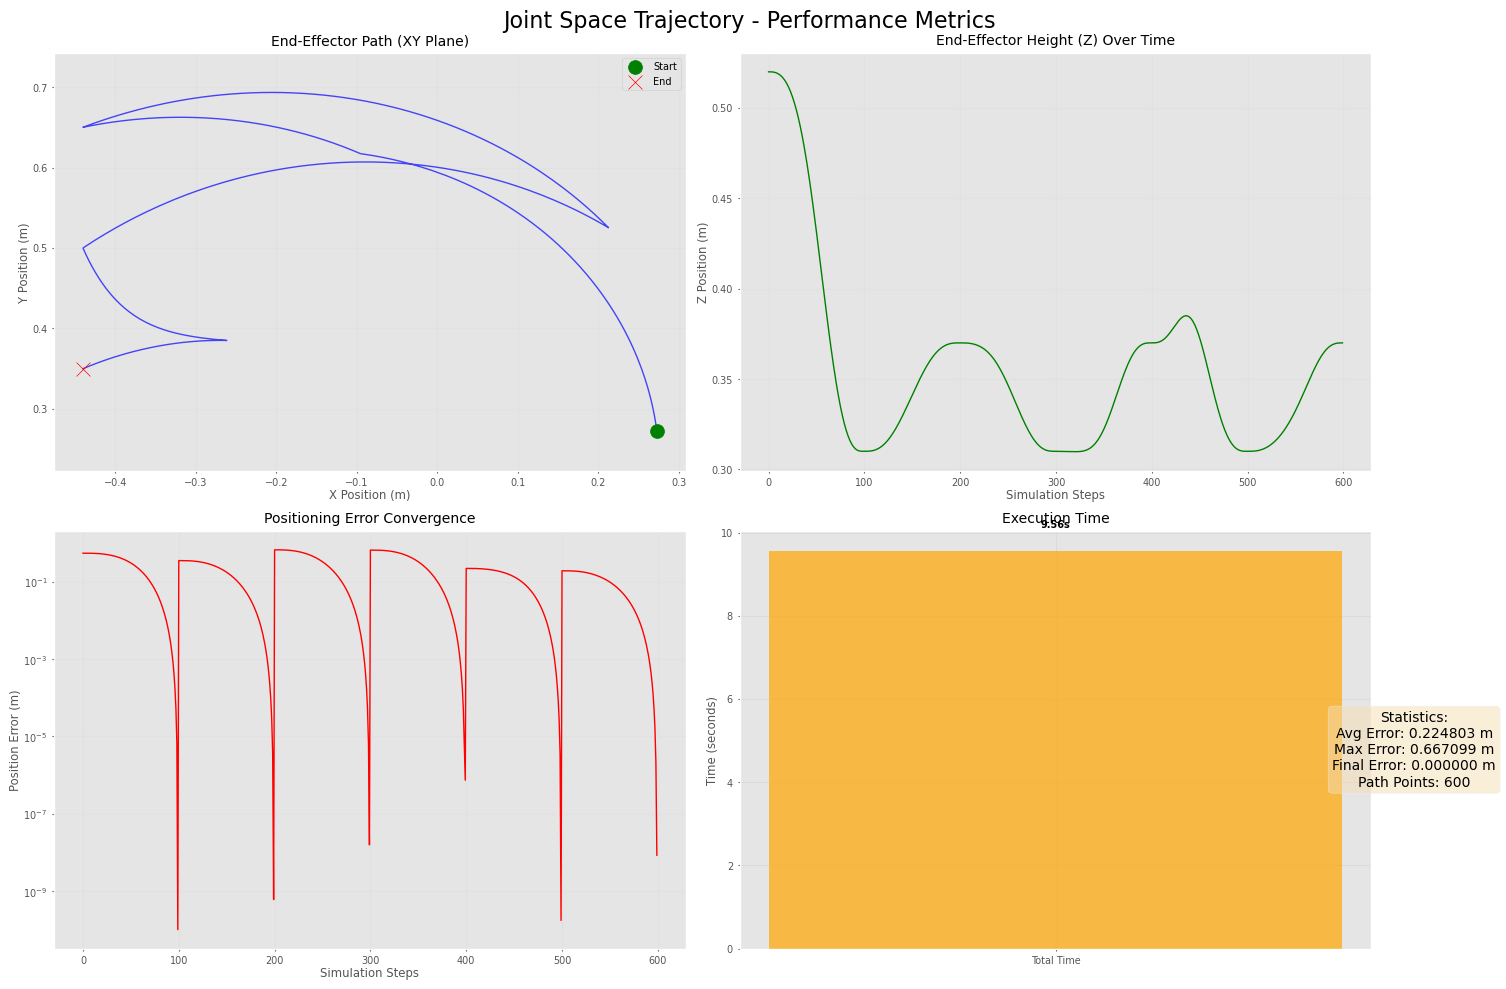


Metrics saved to 'joint_space_metrics.json'


In [ ]:


robot, env, metrics = joint_space_sorting_task(n_berries=3)
plot_metrics(metrics, title="Joint Space Trajectory - Performance Metrics")
import json
with open('joint_space_metrics.json', 'w') as f:
    json_metrics = {
        'execution_time': metrics['execution_time'],
        'path_smoothness': {
            'x': [float(v) for v in metrics['path_smoothness']['x']],
            'y': [float(v) for v in metrics['path_smoothness']['y']],
            'z': [float(v) for v in metrics['path_smoothness']['z']]
        },
        'positioning_accuracy': [float(v) for v in metrics['positioning_accuracy']]
    }
    json.dump(json_metrics, f, indent=2)
print("\nMetrics saved to 'joint_space_metrics.json'")


EXECUTION TIME:
  Joint Space: 9.562791
  Resolved Rate: 18.169608
  Difference: 8.606817
  Percent Change: 90.00% Joint Space is BETTER

TOTAL STEPS:
  Joint Space: 600.000000
  Resolved Rate: 1609.000000
  Difference: 1009.000000
  Percent Change: 168.17% Joint Space is BETTER

AVG ERROR:
  Joint Space: 0.224803
  Resolved Rate: 0.100149
  Difference: -0.124654
  Percent Change: -55.45% Resolved Rate is BETTER

MAX ERROR:
  Joint Space: 0.667099
  Resolved Rate: 0.657427
  Difference: -0.009672
  Percent Change: -1.45% Resolved Rate is BETTER

FINAL ERROR:
  Joint Space: 0.000000
  Resolved Rate: 0.008605
  Difference: 0.008605
  Percent Change: 100705400.93% Joint Space is BETTER

STD ERROR:
  Joint Space: 0.206518
  Resolved Rate: 0.124736
  Difference: -0.081782
  Percent Change: -39.60% Resolved Rate is BETTER

PATH LENGTH:
  Joint Space: 2.776495
  Resolved Rate: 2.589000
  Difference: -0.187495
  Percent Change: -6.75% Resolved Rate is BETTER

SMOOTHNESS AVG ACCEL:
  Joint Spa

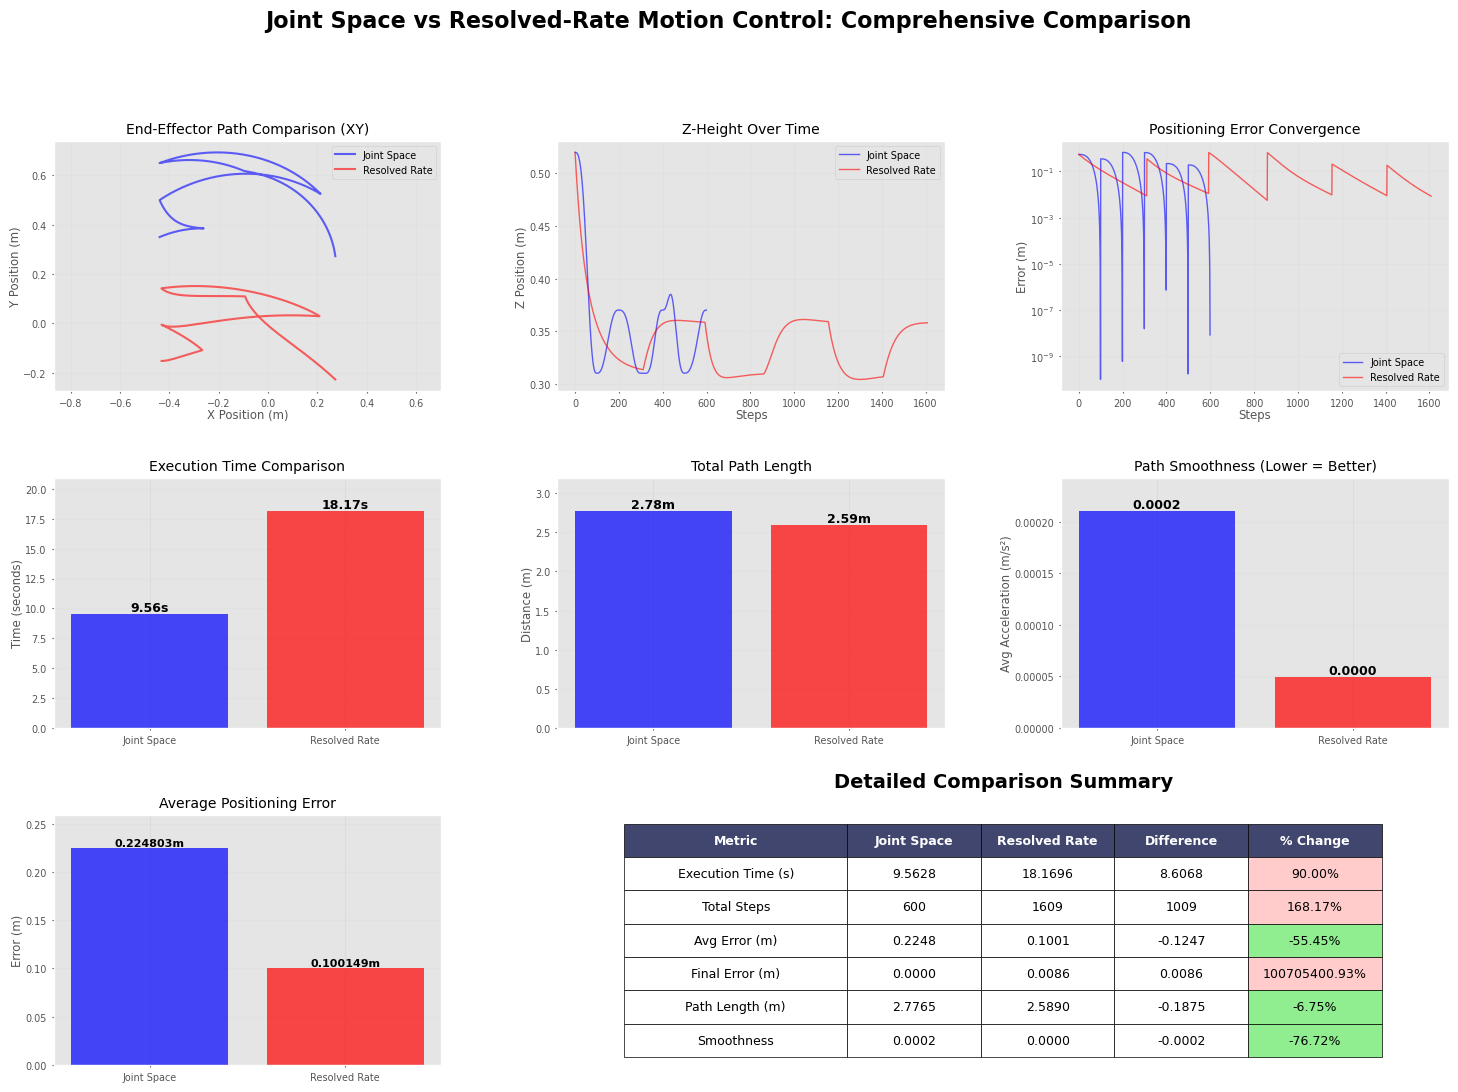

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def load_metrics(joint_space_path='joint_space_metrics.json', 
                 resolved_rate_path='resolved_rate_metrics.json'):
    with open(joint_space_path, 'r') as f:
        joint_metrics = json.load(f)
    with open(resolved_rate_path, 'r') as f:
        resolved_metrics = json.load(f)
    return joint_metrics, resolved_metrics


def calculate_path_smoothness(path_x, path_y, path_z):
    positions = np.array([path_x, path_y, path_z]).T
    # Calculate velocity (first derivative)
    velocities = np.diff(positions, axis=0)
    
    # Calculate acceleration (second derivative)
    accelerations = np.diff(velocities, axis=0)
    
    # Calculate magnitude of accelerations
    acceleration_magnitudes = np.linalg.norm(accelerations, axis=1)
    
    # Return average acceleration (smoothness metric)
    return np.mean(acceleration_magnitudes), np.std(acceleration_magnitudes)


def calculate_statistics(metrics_dict):
    accuracy = metrics_dict['positioning_accuracy']
    path_x = metrics_dict['path_smoothness']['x']
    path_y = metrics_dict['path_smoothness']['y']
    path_z = metrics_dict['path_smoothness']['z']
    positions = np.array([path_x, path_y, path_z]).T
    distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    total_path_length = np.sum(distances)
    avg_accel, std_accel = calculate_path_smoothness(path_x, path_y, path_z)
    
    return {
        'execution_time': metrics_dict['execution_time'],
        'total_steps': len(accuracy),
        'avg_error': np.mean(accuracy),
        'max_error': np.max(accuracy),
        'final_error': accuracy[-1],
        'std_error': np.std(accuracy),
        'path_length': total_path_length,
        'smoothness_avg_accel': avg_accel,
        'smoothness_std_accel': std_accel,
        'avg_step_time': metrics_dict['execution_time'] / len(accuracy)
    }


def compare_metrics_detailed(joint_metrics, resolved_metrics):
    joint_stats = calculate_statistics(joint_metrics)
    resolved_stats = calculate_statistics(resolved_metrics)
    comparison = {}
    for key in joint_stats.keys():
        joint_val = joint_stats[key]
        resolved_val = resolved_stats[key]
        if joint_val != 0:
            percent_diff = ((resolved_val - joint_val) / joint_val) * 100
        else:
            percent_diff = 0
        comparison[key] = {
            'joint_space': joint_val,
            'resolved_rate': resolved_val,
            'difference': resolved_val - joint_val,
            'percent_difference': percent_diff
        }
    return comparison, joint_stats, resolved_stats


def plot_comparison(joint_metrics, resolved_metrics, comparison):
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(joint_metrics['path_smoothness']['x'], 
             joint_metrics['path_smoothness']['y'], 
             'b-', alpha=0.6, linewidth=1.5, label='Joint Space')
    ax1.plot(resolved_metrics['path_smoothness']['x'], 
             resolved_metrics['path_smoothness']['y'], 
             'r-', alpha=0.6, linewidth=1.5, label='Resolved Rate')
    ax1.set_title('End-Effector Path Comparison (XY)')
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # 2. Z-Height Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    steps_joint = np.arange(len(joint_metrics['path_smoothness']['z']))
    steps_resolved = np.arange(len(resolved_metrics['path_smoothness']['z']))
    ax2.plot(steps_joint, joint_metrics['path_smoothness']['z'], 
             'b-', alpha=0.6, linewidth=1, label='Joint Space')
    ax2.plot(steps_resolved, resolved_metrics['path_smoothness']['z'], 
             'r-', alpha=0.6, linewidth=1, label='Resolved Rate')
    ax2.set_title('Z-Height Over Time')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Z Position (m)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Positioning Error Comparison
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(steps_joint, joint_metrics['positioning_accuracy'], 
             'b-', alpha=0.6, linewidth=1, label='Joint Space')
    ax3.plot(steps_resolved, resolved_metrics['positioning_accuracy'], 
             'r-', alpha=0.6, linewidth=1, label='Resolved Rate')
    ax3.set_title('Positioning Error Convergence')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Error (m)')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Execution Time Comparison
    ax4 = fig.add_subplot(gs[1, 0])
    methods = ['Joint Space', 'Resolved Rate']
    times = [comparison['execution_time']['joint_space'], 
             comparison['execution_time']['resolved_rate']]
    colors = ['blue', 'red']
    bars = ax4.bar(methods, times, color=colors, alpha=0.7)
    ax4.set_title('Execution Time Comparison')
    ax4.set_ylabel('Time (seconds)')
    
    # Fixed: Adjust y-limit to make room for text
    max_time = max(times)
    ax4.set_ylim(0, max_time * 1.15)
    
    for i, (bar, time) in enumerate(zip(bars, times)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.2f}s',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Path Length Comparison
    ax5 = fig.add_subplot(gs[1, 1])
    lengths = [comparison['path_length']['joint_space'], 
               comparison['path_length']['resolved_rate']]
    bars = ax5.bar(methods, lengths, color=colors, alpha=0.7)
    ax5.set_title('Total Path Length')
    ax5.set_ylabel('Distance (m)')
    
    # Fixed: Adjust y-limit to make room for text
    max_length = max(lengths)
    ax5.set_ylim(0, max_length * 1.15)
    
    for i, (bar, length) in enumerate(zip(bars, lengths)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{length:.2f}m',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Smoothness Comparison
    ax6 = fig.add_subplot(gs[1, 2])
    smoothness = [comparison['smoothness_avg_accel']['joint_space'], 
                  comparison['smoothness_avg_accel']['resolved_rate']]
    bars = ax6.bar(methods, smoothness, color=colors, alpha=0.7)
    ax6.set_title('Path Smoothness (Lower = Better)')
    ax6.set_ylabel('Avg Acceleration (m/s²)')
    
    # Fixed: Adjust y-limit to make room for text
    max_smooth = max(smoothness)
    ax6.set_ylim(0, max_smooth * 1.15)
    
    for i, (bar, smooth) in enumerate(zip(bars, smoothness)):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{smooth:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Average Error Comparison
    ax7 = fig.add_subplot(gs[2, 0])
    avg_errors = [comparison['avg_error']['joint_space'], 
                  comparison['avg_error']['resolved_rate']]
    bars = ax7.bar(methods, avg_errors, color=colors, alpha=0.7)
    ax7.set_title('Average Positioning Error')
    ax7.set_ylabel('Error (m)')
    
    # Fixed: Adjust y-limit to make room for text
    max_err = max(avg_errors)
    ax7.set_ylim(0, max_err * 1.15)
    
    for i, (bar, err) in enumerate(zip(bars, avg_errors)):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{err:.6f}m',
                ha='center', va='bottom', fontweight='bold', fontsize=8)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Summary Statistics Table
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('off')
    
    # Create comparison table
    table_data = []
    headers = ['Metric', 'Joint Space', 'Resolved Rate', 'Difference', '% Change']
    
    metrics_to_show = [
        ('Execution Time (s)', 'execution_time'),
        ('Total Steps', 'total_steps'),
        ('Avg Error (m)', 'avg_error'),
        ('Final Error (m)', 'final_error'),
        ('Path Length (m)', 'path_length'),
        ('Smoothness', 'smoothness_avg_accel')
    ]
    
    for display_name, key in metrics_to_show:
        comp = comparison[key]
        table_data.append([
            display_name,
            f"{comp['joint_space']:.4f}" if isinstance(comp['joint_space'], float) else str(comp['joint_space']),
            f"{comp['resolved_rate']:.4f}" if isinstance(comp['resolved_rate'], float) else str(comp['resolved_rate']),
            f"{comp['difference']:.4f}" if isinstance(comp['difference'], float) else str(comp['difference']),
            f"{comp['percent_difference']:.2f}%"
        ])
    
    table = ax8.table(cellText=table_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Color code the table header
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code percentage changes
    for i in range(len(table_data)):
        percent_val = float(table_data[i][4].strip('%'))
        if percent_val < 0:
            table[(i+1, 4)].set_facecolor('#90ee90')  # Light green for improvement
        elif percent_val > 0:
            table[(i+1, 4)].set_facecolor('#ffcccb')  # Light red for worse
    
    ax8.set_title('Detailed Comparison Summary', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('Joint Space vs Resolved-Rate Motion Control: Comprehensive Comparison', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    return fig


def print_comparison_report(comparison):
    
    for key, comp in comparison.items():
        print(f"\n{key.upper().replace('_', ' ')}:")
        print(f"  Joint Space: {comp['joint_space']:.6f}")
        print(f"  Resolved Rate: {comp['resolved_rate']:.6f}")
        print(f"  Difference: {comp['difference']:.6f}")
        if comp['percent_difference'] < 0:
            winner = "Resolved Rate is BETTER"
        elif comp['percent_difference'] > 0:
            winner = "Joint Space is BETTER"
        else:
            winner = "= Equal performance"
        
        print(f"  Percent Change: {comp['percent_difference']:.2f}% {winner}")
    
    joint_wins = 0
    resolved_wins = 0
    better_if_lower = ['execution_time', 'avg_error', 'final_error', 
                       'path_length', 'smoothness_avg_accel']
    
    for key in better_if_lower:
        if comparison[key]['percent_difference'] < 0:
            resolved_wins += 1
        elif comparison[key]['percent_difference'] > 0:
            joint_wins += 1

    print()
    if joint_wins > resolved_wins:
        print("JOINT SPACE trajectory control performs better overall")
        print(f"Wins in {joint_wins} out of {joint_wins + resolved_wins} key metrics")
    elif resolved_wins > joint_wins:
        print("RESOLVED-RATE motion control performs better overall")
        print(f"Wins in {resolved_wins} out of {joint_wins + resolved_wins} key metrics")
    else:
        print("  = Both methods show comparable performance")
    

def compare_motion_control_methods(joint_space_path='joint_space_metrics.json',
                                   resolved_rate_path='resolved_rate_metrics.json'):
    joint_metrics, resolved_metrics = load_metrics(joint_space_path, resolved_rate_path)
    comparison, joint_stats, resolved_stats = compare_metrics_detailed(
        joint_metrics, resolved_metrics
    )
    print_comparison_report(comparison)
    plot_comparison(joint_metrics, resolved_metrics, comparison)
    

compare_motion_control_methods()


# Simulating multiple times for statistical robustness


In [8]:
def run_multiple_simulations(n_simulations=10, headless=True):
    """
    Run N simulations for both methods and collect metrics with tqdm progress bars
    """
    from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
    
    all_metrics = {
        'resolved_rate': {
            'execution_times': [],
            'avg_errors': [],
            'final_errors': [],
            'max_errors': [],
            'path_lengths': [],
            'smoothness': [],
            'total_steps': []
        },
        'joint_space': {
            'execution_times': [],
            'avg_errors': [],
            'final_errors': [],
            'max_errors': [],
            'path_lengths': [],
            'smoothness': [],
            'total_steps': []
        }
    }
    
    print(f"Running {n_simulations} simulations for each method...")
    
    # Run resolved-rate simulations with tqdm
    print("\nRESOLVED-RATE SIMULATIONS")
    for i in tqdm(range(n_simulations), desc="Resolved Rate", unit="sim", colour="red"):
        try:
            robot, env, metrics = resolved_rate_of_motion_sorting_task(headless=headless, seed=i)
            
            # Calculate derived metrics
            path_x = metrics['path_smoothness']['x']
            path_y = metrics['path_smoothness']['y']
            path_z = metrics['path_smoothness']['z']
            
            positions = np.array([path_x, path_y, path_z]).T
            distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
            path_length = np.sum(distances)
            
            avg_accel, _ = calculate_path_smoothness(path_x, path_y, path_z)
            
            # Store metrics
            all_metrics['resolved_rate']['execution_times'].append(metrics['execution_time'])
            all_metrics['resolved_rate']['avg_errors'].append(np.mean(metrics['positioning_accuracy']))
            all_metrics['resolved_rate']['final_errors'].append(metrics['positioning_accuracy'][-1])
            all_metrics['resolved_rate']['max_errors'].append(np.max(metrics['positioning_accuracy']))
            all_metrics['resolved_rate']['path_lengths'].append(path_length)
            all_metrics['resolved_rate']['smoothness'].append(avg_accel)
            all_metrics['resolved_rate']['total_steps'].append(len(metrics['positioning_accuracy']))
            
            # Clean up
            del robot, env
            
        except Exception as e:
            tqdm.write(f"Error in simulation {i+1}: {e}")
            continue
    
    # Run joint-space simulations with tqdm
    print("\nJOINT-SPACE SIMULATIONS")
    for i in tqdm(range(n_simulations), desc="Joint Space", unit="sim", colour="blue"):
        try:
            robot, env, metrics = joint_space_sorting_task(headless=headless, seed=i)
            
            # Calculate derived metrics
            path_x = metrics['path_smoothness']['x']
            path_y = metrics['path_smoothness']['y']
            path_z = metrics['path_smoothness']['z']
            
            positions = np.array([path_x, path_y, path_z]).T
            distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
            path_length = np.sum(distances)
            
            avg_accel, _ = calculate_path_smoothness(path_x, path_y, path_z)
            
            # Store metrics
            all_metrics['joint_space']['execution_times'].append(metrics['execution_time'])
            all_metrics['joint_space']['avg_errors'].append(np.mean(metrics['positioning_accuracy']))
            all_metrics['joint_space']['final_errors'].append(metrics['positioning_accuracy'][-1])
            all_metrics['joint_space']['max_errors'].append(np.max(metrics['positioning_accuracy']))
            all_metrics['joint_space']['path_lengths'].append(path_length)
            all_metrics['joint_space']['smoothness'].append(avg_accel)
            all_metrics['joint_space']['total_steps'].append(len(metrics['positioning_accuracy']))
            
            # Clean up
            del robot, env
            
        except Exception as e:
            tqdm.write(f"Error in simulation {i+1}: {e}")
            continue
    
    return all_metrics

In [9]:
def plot_boxplot_comparison(all_metrics, title="Performance Comparison Across Multiple Simulations"):
    from scipy import stats
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import numpy as np
    
    fig = plt.figure(figsize=(20, 12))
    # Adjusted hspace for better vertical separation
    gs = GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.3)
    
    resolved_data = all_metrics['resolved_rate']
    joint_data = all_metrics['joint_space']
    
    # Helper to style boxplots consistently
    def style_boxplot(bp):
        bp['boxes'][0].set_facecolor('#FF9999') # Soft Red
        bp['boxes'][1].set_facecolor('#9999FF') # Soft Blue
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black')

    # 1. Execution Time
    ax1 = fig.add_subplot(gs[0, 0])
    data_to_plot = [resolved_data['execution_times'], joint_data['execution_times']]
    bp1 = ax1.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp1)
    ax1.set_title('Execution Time (s)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Average Error
    ax2 = fig.add_subplot(gs[0, 1])
    data_to_plot = [resolved_data['avg_errors'], joint_data['avg_errors']]
    bp2 = ax2.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp2)
    ax2.set_title('Average Positioning Error (m)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Error (m)')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Final Error
    ax3 = fig.add_subplot(gs[0, 2])
    data_to_plot = [resolved_data['final_errors'], joint_data['final_errors']]
    bp3 = ax3.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp3)
    ax3.set_title('Final Positioning Error (m)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Error (m)')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Max Error
    ax4 = fig.add_subplot(gs[1, 0])
    data_to_plot = [resolved_data['max_errors'], joint_data['max_errors']]
    bp4 = ax4.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp4)
    ax4.set_title('Maximum Error (m)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Error (m)')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Path Length
    ax5 = fig.add_subplot(gs[1, 1])
    data_to_plot = [resolved_data['path_lengths'], joint_data['path_lengths']]
    bp5 = ax5.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp5)
    ax5.set_title('Total Path Length (m)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Distance (m)')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Smoothness
    ax6 = fig.add_subplot(gs[1, 2])
    data_to_plot = [resolved_data['smoothness'], joint_data['smoothness']]
    bp6 = ax6.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp6)
    ax6.set_title('Path Smoothness', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Avg Acceleration (m/s²)')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Total Steps
    ax7 = fig.add_subplot(gs[2, 0])
    data_to_plot = [resolved_data['total_steps'], joint_data['total_steps']]
    bp7 = ax7.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'],
                      patch_artist=True, notch=True, showmeans=True)
    style_boxplot(bp7)
    ax7.set_title('Total Steps', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Number of Steps')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Statistical Summary Table
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('off')
    
    metrics_names = ['Execution Time', 'Avg Error', 'Final Error', 'Max Error', 
                     'Path Length', 'Smoothness', 'Total Steps']
    resolved_keys = ['execution_times', 'avg_errors', 'final_errors', 'max_errors',
                     'path_lengths', 'smoothness', 'total_steps']
    
    table_data = []
    headers = ['Metric', 'Resolved Rate\nMean ± Std', 'Joint Space\nMean ± Std', 
               'p-value', 'Winner']
    
    for metric_name, key in zip(metrics_names, resolved_keys):
        resolved_vals = np.array(resolved_data[key])
        joint_vals = np.array(joint_data[key])
        
        resolved_mean = np.mean(resolved_vals)
        resolved_std = np.std(resolved_vals)
        joint_mean = np.mean(joint_vals)
        joint_std = np.std(joint_vals)
        
        t_stat, p_value = stats.ttest_ind(resolved_vals, joint_vals)
        
        if p_value < 0.05:
            if resolved_mean < joint_mean:
                winner = "Resolved"
            else:
                winner = "Joint"
        else:
            winner = "Tie"
        
        table_data.append([
            metric_name,
            f"{resolved_mean:.3f} ± {resolved_std:.3f}",
            f"{joint_mean:.3f} ± {joint_std:.3f}",
            f"{p_value:.3f}",
            winner
        ])
    
    table = ax8.table(cellText=table_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.20, 0.20, 0.20, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(len(table_data)):
        if 'Resolved' in table_data[i][4]:
            table[(i+1, 4)].set_facecolor('#ffcccb')
        elif 'Joint' in table_data[i][4]:
            table[(i+1, 4)].set_facecolor('#add8e6')
        else:
            table[(i+1, 4)].set_facecolor('#f0f0f0')

    plt.suptitle(title, fontsize=20, fontweight='bold', y=0.98)
    ax8.set_title(f'Statistical Summary (n={len(resolved_data["execution_times"])} simulations)', 
                  fontsize=14, fontweight='bold', y=1.05)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    
    plt.show()

In [ ]:
# For multiple simulations - USE HEADLESS for speed
N_SIMULATIONS = 100
# all_metrics = run_multiple_simulations(n_simulations=N_SIMULATIONS, headless=True)

Running 100 simulations for each method...
⚡ HEADLESS MODE - Simulations will run much faster!


RESOLVED-RATE SIMULATIONS


Resolved Rate:   0%|          | 0/100 [00:00<?, ?sim/s]


JOINT-SPACE SIMULATIONS


Joint Space:   0%|          | 0/100 [00:00<?, ?sim/s]


All simulations completed!


/tmp/ipykernel_96327/965991003.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.94])


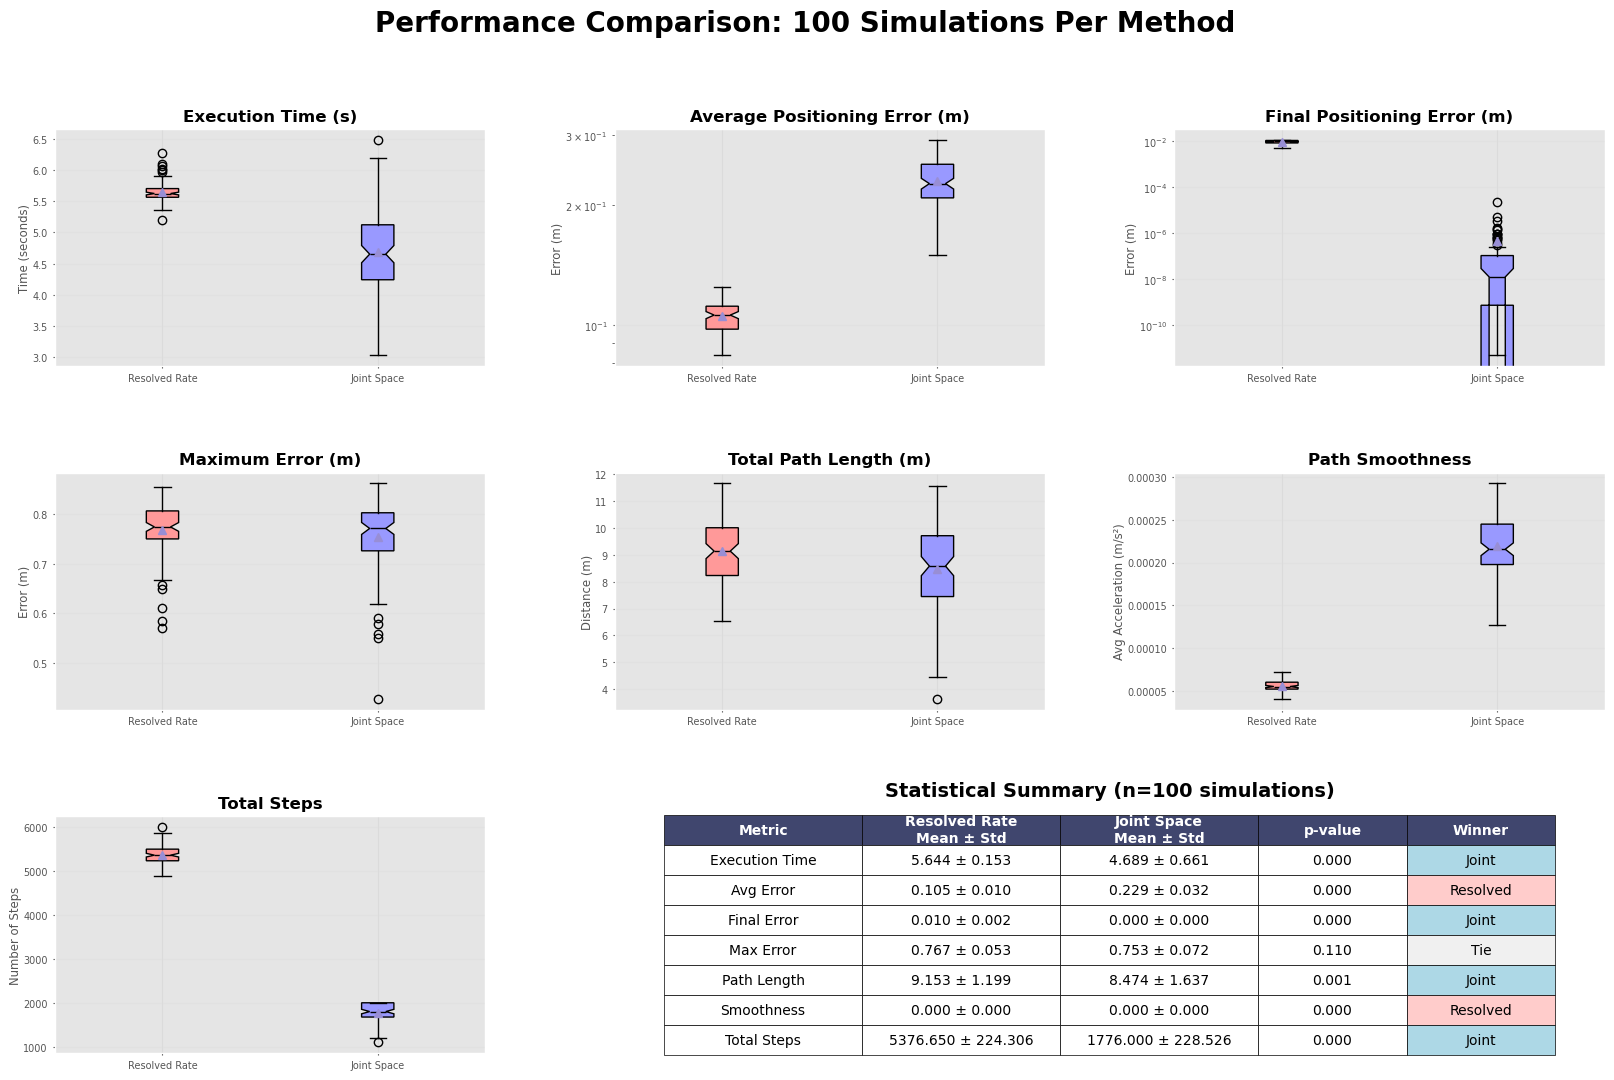

In [ ]:
# Plot boxplot comparison
plot_boxplot_comparison(all_metrics, title=f"Performance Comparison: {N_SIMULATIONS} Simulations Per Method")


# Obstacle avoidance sorting task execution


In [18]:
def plot_obstacle_avoidance_metrics_wall(metrics, wall_data, title="Obstacle Avoidance Metrics"):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path with wall obstacle (XY top-down view)
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 
                   'b-', alpha=0.7, linewidth=1.5, label='Robot Path')
    
    # Draw wall as rectangle (top-down view)
    wall_x = wall_data['position'].x
    wall_y = wall_data['position'].y
    wall_thickness = wall_data['thickness']
    wall_width = wall_data['width']
    
    from matplotlib.patches import Rectangle
    wall_rect = Rectangle(
        (wall_x - wall_thickness/2, wall_y - wall_width/2),  # Bottom-left corner
        wall_thickness,  # Width (thickness in X direction)
        wall_width,      # Height (width in Y direction)
        color='red', alpha=0.4, label='Wall'
    )
    axs[0, 0].add_patch(wall_rect)
    
    # Mark start and end
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                     c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                     c='red', s=100, marker='x', label='End', zorder=5)
    
    axs[0, 0].set_title('Robot Path with Wall Obstacle (XY Plane)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. Obstacle clearance over time
    steps = np.arange(len(metrics['obstacle_clearances']))
    axs[0, 1].plot(steps, metrics['obstacle_clearances'], 'r-', linewidth=1)
    axs[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Collision Threshold')
    
    # Highlight safety margin
    safety_margin = 0.05  # From robot parameters
    axs[0, 1].axhline(y=safety_margin, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Safety Margin')
    
    axs[0, 1].set_title('Minimum Clearance to Wall')
    axs[0, 1].set_xlabel('Simulation Steps')
    axs[0, 1].set_ylabel('Clearance (m)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. 3D Path visualization (XZ side view - shows going over/around wall)
    axs[0, 2].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['z'], 
                   'g-', linewidth=1.5, label='Robot Path')
    
    # Draw wall profile (side view)
    wall_z = wall_data['position'].z
    wall_height = wall_data['height']
    wall_bottom = wall_z - wall_height/2
    wall_top = wall_z + wall_height/2
    
    axs[0, 2].axvspan(wall_x - wall_thickness/2, wall_x + wall_thickness/2, 
                      ymin=(wall_bottom - min(metrics['path_smoothness']['z'])) / 
                            (max(metrics['path_smoothness']['z']) - min(metrics['path_smoothness']['z'])),
                      ymax=(wall_top - min(metrics['path_smoothness']['z'])) / 
                            (max(metrics['path_smoothness']['z']) - min(metrics['path_smoothness']['z'])),
                      color='red', alpha=0.4, label='Wall')
    
    axs[0, 2].set_title('Robot Path (XZ Side View)')
    axs[0, 2].set_xlabel('X Position (m)')
    axs[0, 2].set_ylabel('Z Height (m)')
    axs[0, 2].legend()
    axs[0, 2].grid(True, alpha=0.3)
    
    # 4. Positioning error convergence
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'b-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 5. Clearance histogram
    axs[1, 1].hist(metrics['obstacle_clearances'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    axs[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Collision')
    axs[1, 1].axvline(x=safety_margin, color='orange', linestyle=':', linewidth=2, label='Safety Margin')
    axs[1, 1].set_title('Distribution of Wall Clearances')
    axs[1, 1].set_xlabel('Clearance (m)')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Statistics summary
    axs[1, 2].axis('off')
    
    min_clearance = min(metrics['obstacle_clearances'])
    avg_clearance = np.mean(metrics['obstacle_clearances'])
    collision_detected = min_clearance < 0
    safety_violations = sum(1 for c in metrics['obstacle_clearances'] if c < safety_margin)
    
    stats_text = f"Execution Statistics:\n\n"
    stats_text += f"Total Time: {metrics['execution_time']:.2f} s\n"
    stats_text += f"Total Steps: {len(steps)}\n\n"
    stats_text += f"Wall Avoidance:\n"
    stats_text += f"Min Clearance: {min_clearance:.4f} m\n"
    stats_text += f"Avg Clearance: {avg_clearance:.4f} m\n"
    stats_text += f"Safety Violations: {safety_violations} steps\n"
    stats_text += f"  ({100*safety_violations/len(steps):.1f}% of path)\n"
    stats_text += f"Collisions: {'YES ⚠️' if collision_detected else 'NO ✓'}\n\n"
    stats_text += f"Positioning:\n"
    stats_text += f"Avg Error: {np.mean(metrics['positioning_accuracy']):.6f} m\n"
    stats_text += f"Final Error: {metrics['positioning_accuracy'][-1]:.6f} m\n\n"
    stats_text += f"Path Efficiency:\n"
    stats_text += f"Total Path Points: {len(metrics['path_smoothness']['x'])}"
    
    axs[1, 2].text(0.1, 0.5, stats_text, fontsize=18, verticalalignment='center',
                  fontfamily='monospace',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [19]:
def generate_fixed_berry_positions_circular(num_berries, table_position_x, table_position_y, table_position_z, 
                                            table_height, table_depth, table_width, berry_radius, seed=42,
                                            circle_center_x_offset=0.0, circle_center_y_offset=0.0, 
                                            circle_radius=0.15):
    np.random.seed(seed)
    
    circle_center_x = table_position_x + circle_center_x_offset
    circle_center_y = table_position_y + circle_center_y_offset
    z = table_position_z + table_height/2 + berry_radius
    
    berry_data = []
    
    for _ in range(num_berries):
        r = circle_radius * np.sqrt(np.random.uniform(0, 1))  # sqrt for uniform distribution
        theta = np.random.uniform(0, 2 * np.pi)
        x = circle_center_x + r * np.cos(theta)
        y = circle_center_y + r * np.sin(theta)
        x = np.clip(x, 
                   table_position_x - table_depth/2 + berry_radius + 0.05,
                   table_position_x + table_depth/2 - berry_radius - 0.05)
        y = np.clip(y,
                   table_position_y - table_width/2 + berry_radius + 0.05,
                   table_position_y + table_width/2 - berry_radius - 0.05)
        
        position = sm.SE3(x, y, z)
        color = colors[np.random.choice(len(colors))]
        
        berry_data.append((position, color))
    
    return berry_data

def obstacle_avoidance_sorting_task():
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': [],
        'obstacle_clearances': []  # Track minimum distances to obstacles
    }

    env = Environment()
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    table_position_x = 0.0
    table_position_y = 0.0
    table_position_z = 0.25
    berry_radius = 0.02
    
    robot_base_x = 0.0
    robot_base_y = -0.5
    robot_base_z = 0.0
    
    box1_position_y = 0.0
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    # Create table and boxes
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotResolvedRate(base_position=sm.SE3(robot_base_x, robot_base_y, robot_base_z))
    
    # Fine-tuned parameters for wall avoidance
    robot.set_avoidance_parameters(
    repulsive_gain=0.1,      # Moderate repulsion
    influence_distance=0.30,   # Start repelling early but gently
    safety_margin=0.15         # Reasonable safety distance
    )
    wall_height = 0.05  # Height of the wall
    wall_width = table_width  # Same width as table
    wall_thickness = 0.02  # Thin wall
    wall_position_x = table_position_x - 0.15  # Between berry area and box area
    wall_position_y = table_position_y  # Centered on table
    wall_position_z = table_position_z + table_height/2 + wall_height/2
    wall = sg.Cuboid(
        scale=[wall_thickness, wall_width, wall_height],
        pose=sm.SE3(wall_position_x, wall_position_y, wall_position_z),
        color=[0.5, 0.5, 0.5, 1]  # Gray with some transparency
    )
    obstacles_data = []
    num_points = 10  # Number of sample points along the wall
    for i in range(num_points):
        # Points along the width of the wall
        y_offset = -wall_width/2 + (wall_width / (num_points-1)) * i
        obs_pos = sm.SE3(
            wall_position_x - wall_thickness/2,  # Front face of wall (robot side)
            wall_position_y + y_offset,
            wall_position_z
        )
        obstacles_data.append({
            'position': obs_pos,
            'radius': wall_thickness/2,  # Half thickness as radius
            'height': wall_height,
            'type': 'wall'
        })
    
    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.add(wall)
    env.swift_env.step(1)
    box1_center = sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z + box_height/3)
    box2_center = sm.SE3(box1_position_x, box1_position_y, box1_position_z + box_height/3)
    box3_center = sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z + box_height/3)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)

    total_berries = 3

    berry_positions = generate_fixed_berry_positions_circular(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=42,
        circle_center_x_offset=0.2,  # 20cm in front of table center (toward robot)
        circle_center_y_offset=0.0,  # Centered laterally
        circle_radius=0.12  # 12cm radius circle
    )

    def move_with_obstacle_avoidance(target_pose):
        errors_history = []
        max_iterations = 10000
        iteration = 0
        
        while iteration < max_iterations:
            current_error, current_pos = robot.move_to_target_with_obstacle_avoidance(target_pose, obstacles_data)
            
            metrics['positioning_accuracy'].append(current_error)
            metrics['path_smoothness']['x'].append(current_pos[0])
            metrics['path_smoothness']['y'].append(current_pos[1])
            metrics['path_smoothness']['z'].append(current_pos[2])
            wall_front_x = wall_position_x - wall_thickness/2
            distance_to_wall_x = abs(current_pos[0] - wall_front_x)

            within_y = abs(current_pos[1] - wall_position_y) <= wall_width/2
            within_z = abs(current_pos[2] - wall_position_z) <= wall_height/2
            
            if within_y and within_z:
                min_clearance = distance_to_wall_x
            else:
                # Calculate distance to nearest edge/corner
                min_clearance = float('inf')
                for obs in obstacles_data:
                    obs_pos = np.array([obs['position'].x, obs['position'].y, obs['position'].z])
                    distance = np.linalg.norm(current_pos - obs_pos) - obs['radius']
                    min_clearance = min(min_clearance, distance)
            
            metrics['obstacle_clearances'].append(min_clearance)
            
            env.swift_env.step(robot.dt)
            errors_history.append(current_error)
            
            if robot.has_converged(errors_history):
                robot.reset_error()
                break
            
            iteration += 1
        

    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)
    
    start_time = time.time()

    for i, berry in enumerate(env.berries):
        print(f"\n--- Processing Berry {i+1}/{len(env.berries)} ---")
        
        # Phase 1: Move to berry (no obstacle between robot and berries)
        target_pose = berry.pose
        move_with_obstacle_avoidance(target_pose)
        
        # Phase 2: Pick up berry
        robot.pick_berry(berry)
        time.sleep(0.2)

        # Phase 3: Move over the wall to appropriate box
        drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
        
        move_with_obstacle_avoidance(drop_center)

        # Phase 4: Drop berry
        robot.drop_berry_at(drop_center)
        
        if berry.random_color == red:
            env.swift_env.add(red_center_marker)
        elif berry.random_color == green:
            env.swift_env.add(green_center_marker)
        else:
            env.swift_env.add(blue_center_marker)


        time.sleep(0.2)
    

    # End timing
    metrics['execution_time'] = time.time() - start_time

    # Print obstacle clearance statistics
    min_clearance = min(metrics['obstacle_clearances'])
    avg_clearance = np.mean(metrics['obstacle_clearances'])

    # Prepare wall data for visualization
    wall_viz_data = {
        'position': sm.SE3(wall_position_x, wall_position_y, wall_position_z),
        'width': wall_width,
        'height': wall_height,
        'thickness': wall_thickness
    }

    plot_obstacle_avoidance_metrics_wall(metrics, wall_viz_data, 
                                title="Obstacle Avoidance with Wall - Performance Analysis")

    return robot, env, metrics


--- Processing Berry 1/3 ---

--- Processing Berry 2/3 ---

--- Processing Berry 2/3 ---

--- Processing Berry 3/3 ---

--- Processing Berry 3/3 ---


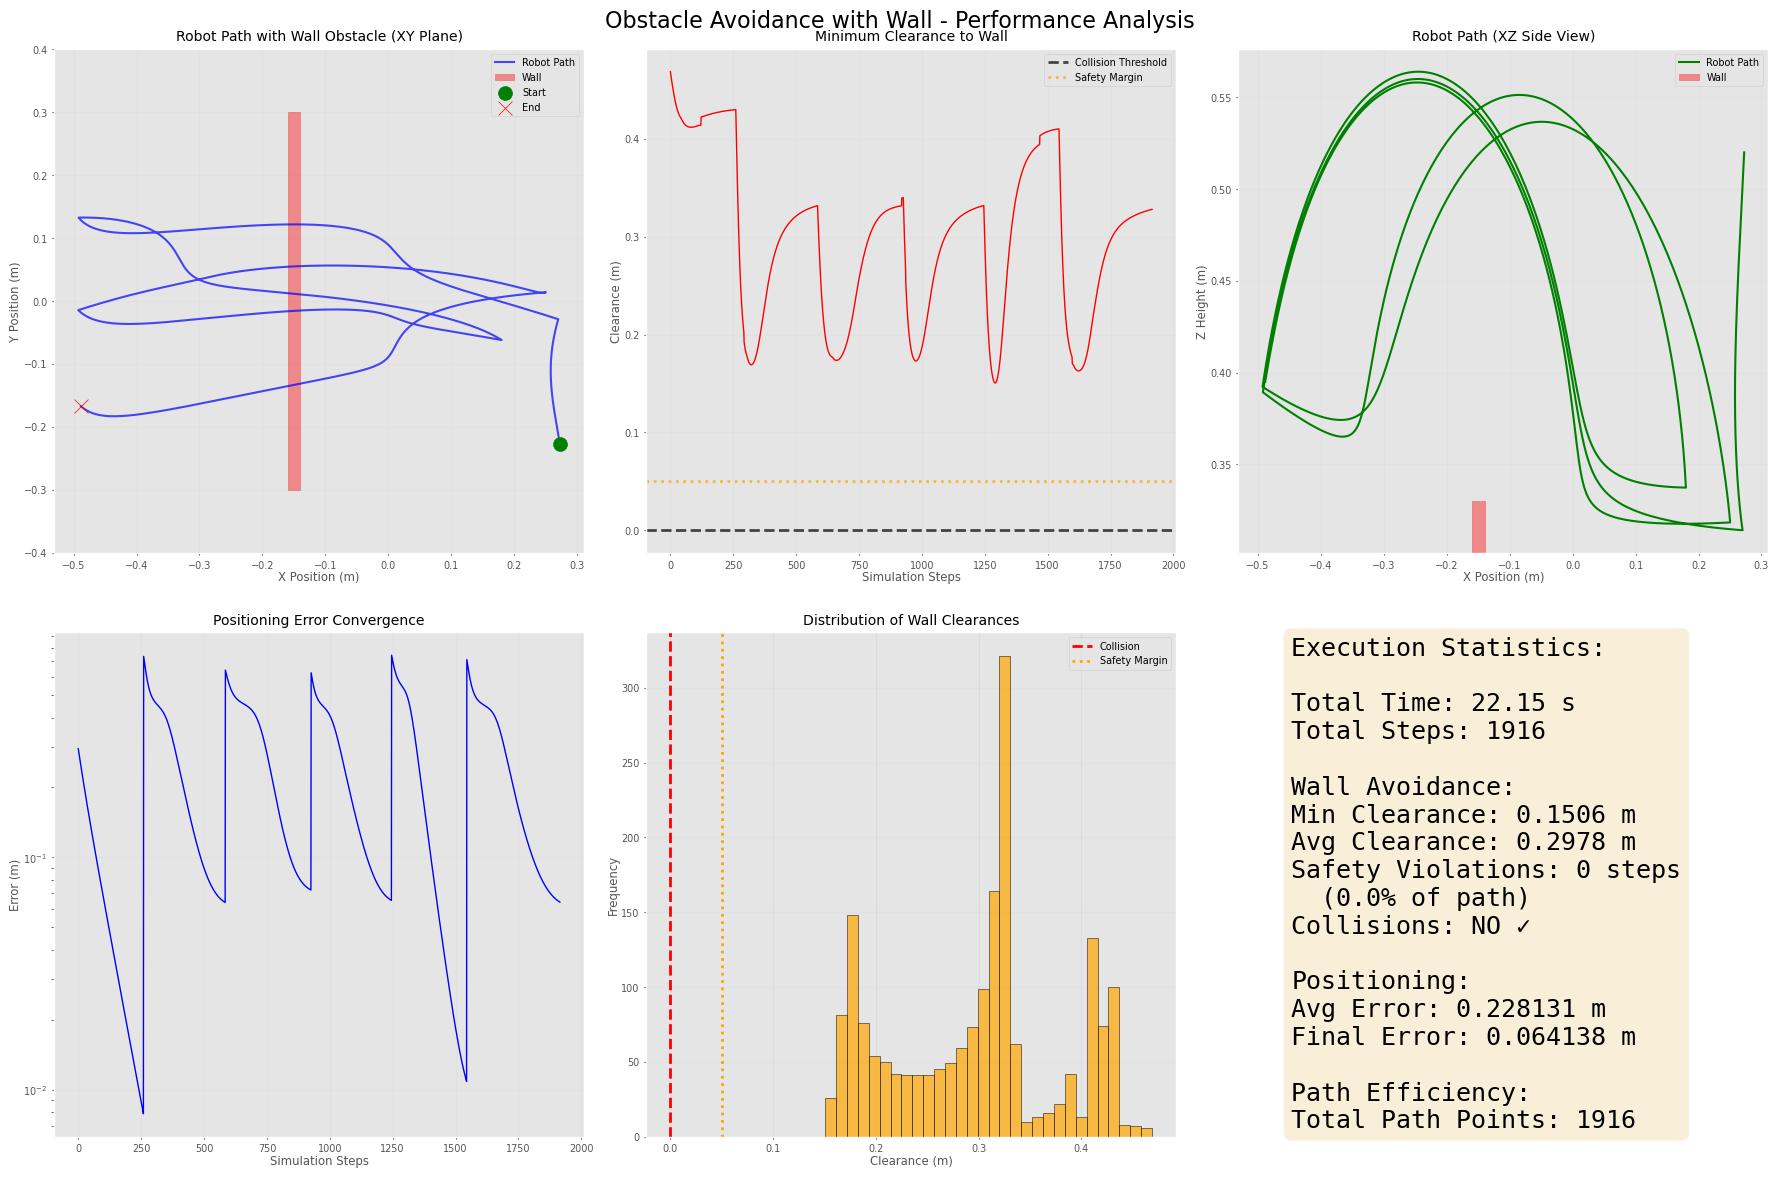

In [20]:
robot_oa, env_oa, metrics_oa = obstacle_avoidance_sorting_task()

In [29]:
def plot_obstacle_avoidance_metrics_pyramid(metrics, obstacle_data, title="Obstacle Avoidance Metrics"):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path with pyramid obstacle (XY top-down view)
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 
                   'b-', alpha=0.7, linewidth=1.5, label='Robot Path')
    
    # Draw pyramid as square (top-down view shows base)
    pyramid_x = obstacle_data['position'].x
    pyramid_y = obstacle_data['position'].y
    pyramid_base_size = obstacle_data['width']  # Base size of pyramid
    
    from matplotlib.patches import Rectangle
    pyramid_rect = Rectangle(
        (pyramid_x - pyramid_base_size/2, pyramid_y - pyramid_base_size/2),
        pyramid_base_size,
        pyramid_base_size,
        color='brown', alpha=0.4, label='Pyramid Base', 
        edgecolor='darkred', linewidth=2
    )
    axs[0, 0].add_patch(pyramid_rect)
    
    # Mark pyramid center
    axs[0, 0].scatter(pyramid_x, pyramid_y, c='darkred', s=50, marker='x', 
                     label='Pyramid Center', zorder=5)
    
    # Mark start and end of path
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                     c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                     c='red', s=100, marker='x', label='End', zorder=5)
    
    axs[0, 0].set_title('Robot Path with Pyramid Obstacle (XY Top View)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend(loc='best', fontsize=9)
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. Obstacle clearance over time
    steps = np.arange(len(metrics['obstacle_clearances']))
    axs[0, 1].plot(steps, metrics['obstacle_clearances'], 'r-', linewidth=1)
    axs[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Collision Threshold')
    
    # Highlight safety margin
    safety_margin = 0.08  # From pyramid parameters
    axs[0, 1].axhline(y=safety_margin, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Safety Margin')
    
    axs[0, 1].set_title('Minimum Clearance to Pyramid')
    axs[0, 1].set_xlabel('Simulation Steps')
    axs[0, 1].set_ylabel('Clearance (m)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. 3D Path visualization (XZ side view - shows climbing over pyramid)
    axs[0, 2].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['z'], 
                   'g-', linewidth=1.5, label='Robot Path')
    
    # Draw pyramid profile (side view - triangular shape)
    pyramid_z = obstacle_data['position'].z
    pyramid_height = obstacle_data['height']
    pyramid_base = pyramid_z - pyramid_height/2
    pyramid_top = pyramid_z + pyramid_height/2
    
    # Create triangle for pyramid side profile
    from matplotlib.patches import Polygon
    pyramid_profile = Polygon([
        [pyramid_x - pyramid_base_size/2, pyramid_base],  # Left base
        [pyramid_x + pyramid_base_size/2, pyramid_base],  # Right base
        [pyramid_x, pyramid_top]                           # Top apex
    ], color='brown', alpha=0.4, label='Pyramid Profile', edgecolor='darkred', linewidth=2)
    axs[0, 2].add_patch(pyramid_profile)
    
    axs[0, 2].set_title('Robot Path (XZ Side View - Climbing Trajectory)')
    axs[0, 2].set_xlabel('X Position (m)')
    axs[0, 2].set_ylabel('Z Height (m)')
    axs[0, 2].legend()
    axs[0, 2].grid(True, alpha=0.3)
    
    # 4. Positioning error convergence
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'b-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 5. Clearance histogram
    axs[1, 1].hist(metrics['obstacle_clearances'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    axs[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Collision')
    axs[1, 1].axvline(x=safety_margin, color='orange', linestyle=':', linewidth=2, label='Safety Margin')
    axs[1, 1].set_title('Distribution of Pyramid Clearances')
    axs[1, 1].set_xlabel('Clearance (m)')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Statistics summary
    axs[1, 2].axis('off')
    
    min_clearance = min(metrics['obstacle_clearances'])
    avg_clearance = np.mean(metrics['obstacle_clearances'])
    collision_detected = min_clearance < 0
    safety_violations = sum(1 for c in metrics['obstacle_clearances'] if c < safety_margin)
    
    # Calculate maximum height reached
    max_height = max(metrics['path_smoothness']['z'])
    base_height = obstacle_data['position'].z - obstacle_data['height']/2
    height_gain = max_height - base_height
    
    stats_text = f"Execution Statistics:\n\n"
    stats_text += f"Total Time: {metrics['execution_time']:.2f} s\n"
    stats_text += f"Total Steps: {len(steps)}\n\n"
    stats_text += f"Pyramid Climbing:\n"
    stats_text += f"Pyramid Height: {obstacle_data['height']:.2f} m\n"
    stats_text += f"Max Height Reached: {max_height:.3f} m\n"
    stats_text += f"Height Gain: {height_gain:.3f} m\n\n"
    stats_text += f"Obstacle Avoidance:\n"
    stats_text += f"Min Clearance: {min_clearance:.4f} m\n"
    stats_text += f"Avg Clearance: {avg_clearance:.4f} m\n"
    stats_text += f"Safety Violations: {safety_violations} steps\n"
    stats_text += f"  ({100*safety_violations/len(steps):.1f}% of path)\n"
    stats_text += f"Collisions: {'YES ⚠️' if collision_detected else 'NO ✓'}\n\n"
    stats_text += f"Positioning:\n"
    stats_text += f"Avg Error: {np.mean(metrics['positioning_accuracy']):.6f} m\n"
    stats_text += f"Final Error: {metrics['positioning_accuracy'][-1]:.6f} m\n\n"
    stats_text += f"Path Efficiency:\n"
    stats_text += f"Total Path Points: {len(metrics['path_smoothness']['x'])}"
    
    # incrase size of the image
    axs[1, 2].text(0.2, 0.5, stats_text, fontsize=14, verticalalignment='center',
                  fontfamily='monospace',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [30]:
def create_pyramid_obstacle(base_x, base_y, base_z, base_size, height, num_layers=5):
    obstacles_data = []
    pyramid_parts = []
    for layer in range(num_layers):
        layer_height = height / num_layers
        layer_z = base_z + layer * layer_height
        size_ratio = 1.0 - (layer / num_layers)
        layer_size = base_size * size_ratio
        if layer_size < 0.02:  # Stop if too small
            break
        layer_cuboid = sg.Cuboid(
            scale=[layer_size, layer_size, layer_height],
            pose=sm.SE3(base_x, base_y, layer_z),
            color=[0.6, 0.4, 0.2, 0.8]  # Brown/tan color
        )
        pyramid_parts.append(layer_cuboid)
        num_points_per_side = max(3, int(6 * size_ratio))
        for side in range(4):
            for i in range(num_points_per_side):
                t = i / (num_points_per_side - 1) if num_points_per_side > 1 else 0.5
                
                if side == 0:  # Front face (towards robot)
                    x = base_x - layer_size/2
                    y = base_y - layer_size/2 + layer_size * t
                elif side == 1:  # Right face
                    x = base_x - layer_size/2 + layer_size * t
                    y = base_y + layer_size/2
                elif side == 2:  # Back face
                    x = base_x + layer_size/2
                    y = base_y - layer_size/2 + layer_size * t
                else:  # Left face
                    x = base_x - layer_size/2 + layer_size * t
                    y = base_y - layer_size/2
                
                obs_pos = sm.SE3(x, y, layer_z)
                obstacles_data.append({
                    'position': obs_pos,
                    'radius': layer_height / 2,  # Effective radius
                    'type': 'pyramid_layer',
                    'layer': layer
                })
    
    return pyramid_parts, obstacles_data


def obstacle_avoidance_sorting_task_pyramid():
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': [],
        'obstacle_clearances': []
    }

    env = Environment()
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    table_position_x = 0.0
    table_position_y = 0.0
    table_position_z = 0.25
    berry_radius = 0.02
    
    robot_base_x = 0.0
    robot_base_y = -0.5
    robot_base_z = 0.0
    
    box1_position_y = 0.0
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    # Create table and boxes
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotResolvedRate(base_position=sm.SE3(robot_base_x, robot_base_y, robot_base_z))
    
    # TUNED parameters for pyramid climbing
    robot.set_avoidance_parameters(
        repulsive_gain=0.3,       # Higher gain to push robot up the slope
        influence_distance=0.03,   # Larger influence to feel the pyramid early
        safety_margin=0.08         # Larger margin to avoid getting stuck
    )

    pyramid_base_x = table_position_x - 0.15  # Between berries and boxes
    pyramid_base_y = table_position_y          # Centered
    pyramid_base_z = table_position_z + table_height/2  # On table surface
    pyramid_base_size = 0.25  # 25cm base
    pyramid_height = 0.15     # 15cm tall
    
    pyramid_parts, obstacles_data = create_pyramid_obstacle(
        pyramid_base_x, pyramid_base_y, pyramid_base_z,
        pyramid_base_size, pyramid_height, num_layers=8
    )
    
    # Add all objects to Swift environment
    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    
    # Add pyramid layers
    for part in pyramid_parts:
        env.swift_env.add(part)
    
    env.swift_env.step(1)

    box1_center = sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z + box_height/3)
    box2_center = sm.SE3(box1_position_x, box1_position_y, box1_position_z + box_height/3)
    box3_center = sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z + box_height/3)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)

    total_berries = 3

    berry_positions = generate_fixed_berry_positions_circular(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=42,
        circle_center_x_offset=0.2,
        circle_center_y_offset=0.0,
        circle_radius=0.12
    )

    def move_with_obstacle_avoidance(target_pose):
        errors_history = []
        max_iterations = 4000  # More iterations for complex path
        iteration = 0
        
        while iteration < max_iterations:
            current_error, current_pos = robot.move_to_target_with_obstacle_avoidance(target_pose, obstacles_data)
            
            metrics['positioning_accuracy'].append(current_error)
            metrics['path_smoothness']['x'].append(current_pos[0])
            metrics['path_smoothness']['y'].append(current_pos[1])
            metrics['path_smoothness']['z'].append(current_pos[2])
            
            # Calculate minimum clearance to pyramid
            min_clearance = float('inf')
            for obs in obstacles_data:
                obs_pos = np.array([obs['position'].x, obs['position'].y, obs['position'].z])
                distance = np.linalg.norm(current_pos - obs_pos) - obs['radius']
                min_clearance = min(min_clearance, distance)
            
            metrics['obstacle_clearances'].append(min_clearance)
            
            env.swift_env.step(robot.dt)
            errors_history.append(current_error)
            
            if robot.has_converged(errors_history):
                robot.reset_error()
                break
            
            iteration += 1
        
        if iteration >= max_iterations:
            print(f"Warning: Max iterations reached")
            robot.reset_error()

    # Create berries
    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)
    
    # Start timing
    start_time = time.time()

    for i, berry in enumerate(env.berries):
        print(f"\n--- Processing Berry {i+1}/{len(env.berries)} ---")
        
        # Phase 1: Move to berry
        target_pose = berry.pose
        move_with_obstacle_avoidance(target_pose)
        
        # Phase 2: Pick up berry
        robot.pick_berry(berry)
        time.sleep(0.2)

        # Phase 3: Move to box (robot will climb pyramid naturally!)
        drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
        
        move_with_obstacle_avoidance(drop_center)

        # Phase 4: Drop berry
        robot.drop_berry_at(drop_center)
        
        if berry.random_color == red:
            env.swift_env.add(red_center_marker)
        elif berry.random_color == green:
            env.swift_env.add(green_center_marker)
        else:
            env.swift_env.add(blue_center_marker)

        time.sleep(0.2)
    
    # End timing
    metrics['execution_time'] = time.time() - start_time

    pyramid_viz_data = {
        'position': sm.SE3(pyramid_base_x, pyramid_base_y, pyramid_base_z + pyramid_height/2),
        'width': pyramid_base_size,
        'height': pyramid_height,
        'thickness': pyramid_base_size / 2  # For visualization
    }

    plot_obstacle_avoidance_metrics_pyramid(metrics, pyramid_viz_data, 
                                title="Pyramid Obstacle Climbing - Repulsion-Based Navigation")

    return robot, env, metrics


--- Processing Berry 1/3 ---

--- Processing Berry 2/3 ---

--- Processing Berry 2/3 ---

--- Processing Berry 3/3 ---

--- Processing Berry 3/3 ---


/tmp/ipykernel_117261/125818040.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  pyramid_rect = Rectangle(
/tmp/ipykernel_117261/125818040.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  pyramid_profile = Polygon([


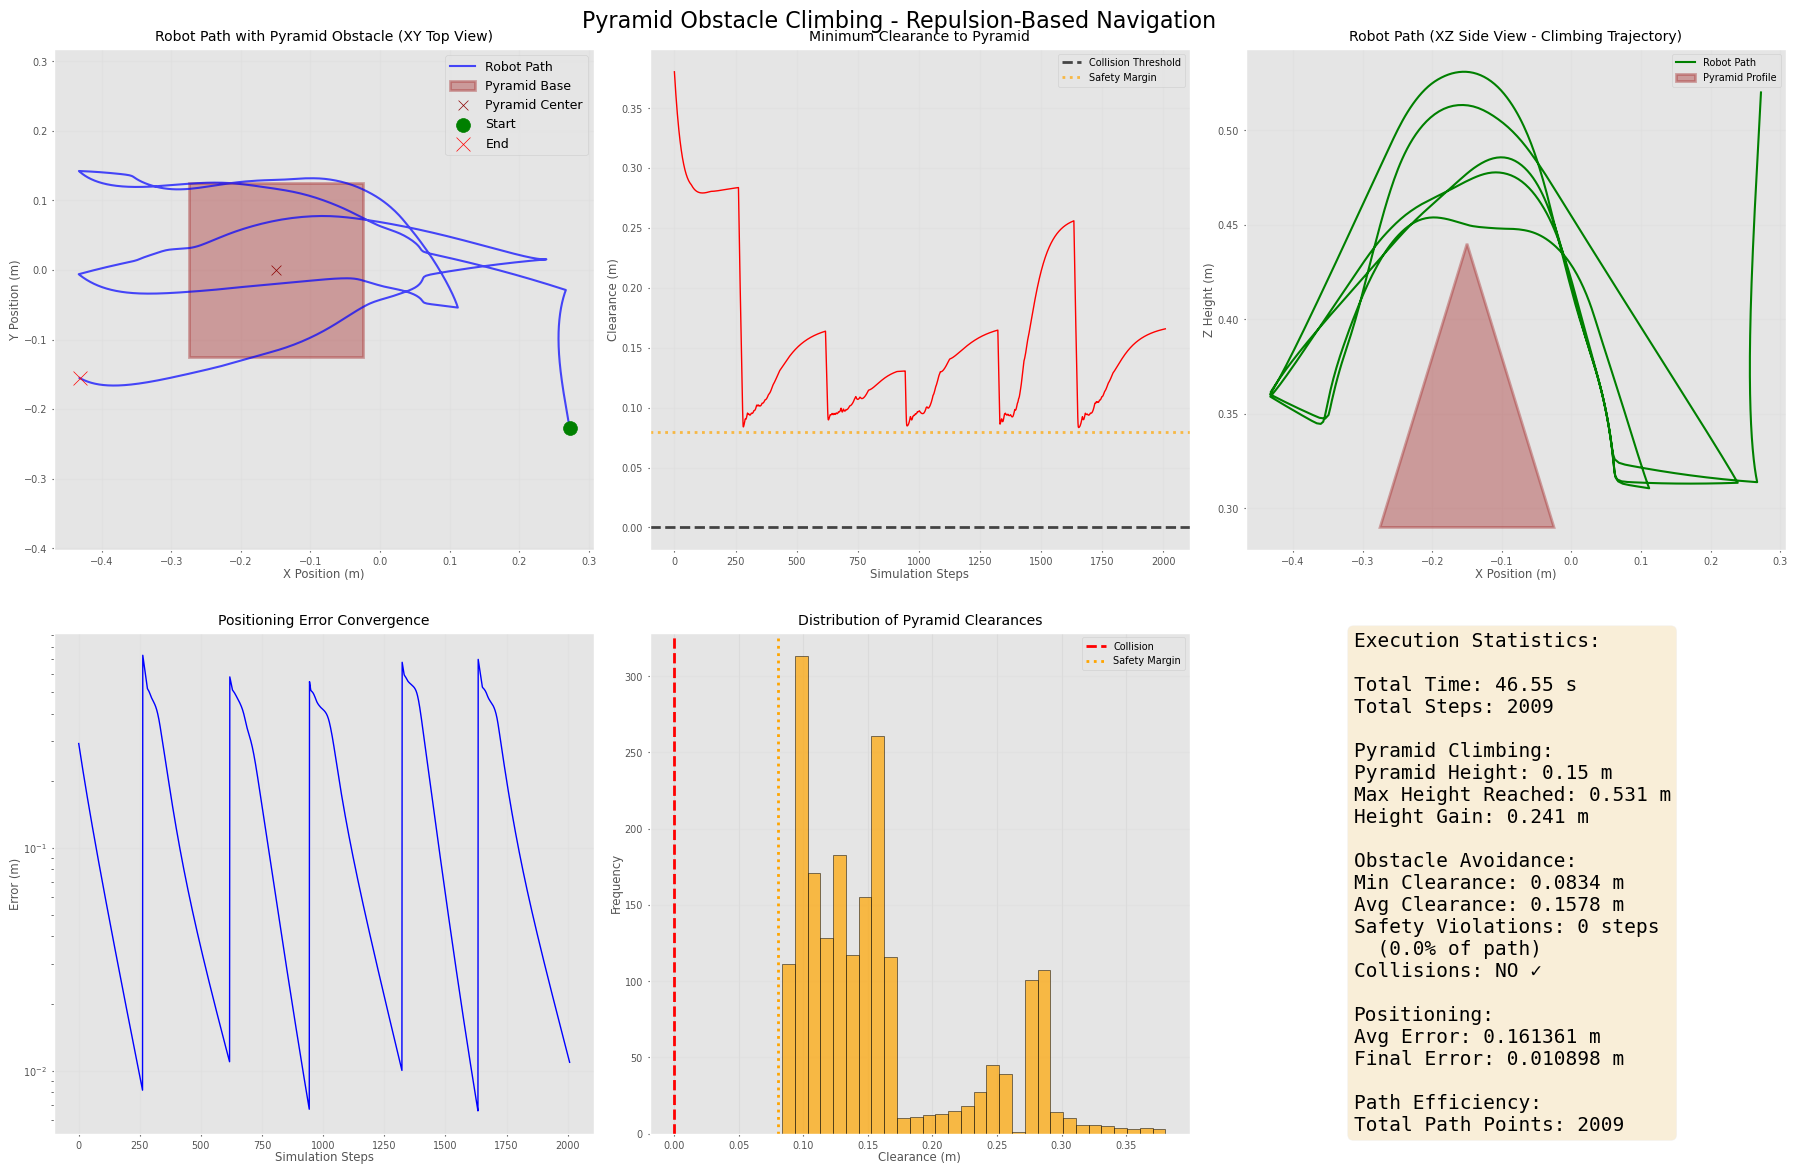

In [31]:
robot_pyr, env_pyr, metrics_pyr = obstacle_avoidance_sorting_task_pyramid()